## Is the Review a Spoiler?

In this part of the project, I would like to determine if a review is a spoiler or not. 
This analysis will be based on text similarity. The way to implement text similarity is to use particular techniques to find the closeness between two chunks of text. That being said, I will implement some methods to compare between the plot of a movie and a review to see if there is enough similarity between the two of them to make a review a spoiler.
The statistical methods  that I will use to investigate the text similarity are.
    * Cosine similarity
    * Jaccard Similarity 
    * Word Mover’s Distance 
All of them require preprocessing of the text to make it a vector. 




# Preprocessing the Data

In this part of my project, I will switch to another dataset from kaggle (https://www.kaggle.com/rmisra/imdb-spoiler-dataset) which is not that much different from the one that I scraped but way much smaller. In fact, one table has around 1500 movies with their plot_summaries (which was not enough for me to make my initial analysis). The second table lists the reviews of the movies in table 1. However, this table is really huge and I only used a fraction of it to conduct the following analysis.

Let's begin by processing the data and make it suitable to work with.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import string
import re
import joblib
from itertools import compress
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

In [35]:
# import the first table and get a look at it
df_movies = pd.read_json('/Users/SanaKrichen/Desktop/BrainStation/Capstone Project/IMDB_movie_details.json',lines=True)
df_movies.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [36]:
# notice that some plots are missing!!

df_movies['plot_synopsis']

0       Jack Ryan (Ford) is on a "working vacation" in...
1       Four boys around the age of 10 are friends in ...
2                                                        
3       Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4       Jim McAllister (Matthew Broderick) is a much-a...
                              ...                        
1567    In the year 1998, Evan Treborn (Ashton Kutcher...
1568    Brandon (Michael Fassbender) is a successful, ...
1569    The film alternates between three different pe...
1570                                                     
1571                                                     
Name: plot_synopsis, Length: 1572, dtype: object

In [37]:
# let's filter out the rows with the missing plots
df_movies[df_movies['plot_synopsis']=='']

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
10,tt0107131,"Three pets (Chance, a young dog unfamiliar wit...",1h 24min,"[Adventure, Comedy, Drama]",6.9,1993-02-12,
11,tt0110364,"In Urbania, Ohio, snobby ex-football star Kevi...",1h 47min,"[Comedy, Family, Sport]",6.3,1994-10-14,
22,tt0101700,The story is centered on a microcosm of a post...,1h 39min,"[Comedy, Crime]",7.7,1992-04-03,
24,tt0102768,Henry is a lawyer who survives a shooting only...,1h 48min,"[Drama, Romance]",6.7,1991-07-10,
...,...,...,...,...,...,...,...
1556,tt0285531,"Four childhood friends, Jonesy, Beaver, Pete a...",2h 14min,"[Drama, Horror, Sci-Fi]",5.5,2003-03-21,
1564,tt0914798,Young Bruno lives a wealthy lifestyle in prewa...,1h 34min,"[Drama, War]",7.8,2008-11-26,
1566,tt4047038,Centers on the titular holistic detective who ...,1h,"[Comedy, Mystery, Sci-Fi]",8.4,2017-04-01,
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


In [38]:
# store the list of the unique identifiers of the movies with null plots just in case I need it 
to_delete=df_movies[df_movies['plot_synopsis']=='']['movie_id']
to_delete

2        tt0243655
10       tt0107131
11       tt0110364
22       tt0101700
24       tt0102768
           ...    
1556     tt0285531
1564     tt0914798
1566     tt4047038
1570    tt0104014/
1571    tt0114142/
Name: movie_id, Length: 233, dtype: object

In [39]:
# drop all the movies with no plots and save my new dataframe

df_movies.drop(list(df_movies[df_movies['plot_synopsis']==''].index), inplace = True)
df_movies.reset_index(inplace = True, drop = True) 
df_movies

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
3,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
4,tt0286716,"Bruce Banner, a brilliant scientist with a clo...",2h 18min,"[Action, Sci-Fi]",5.7,2003-06-20,Bruce Banner (Eric Bana) is a research scienti...
...,...,...,...,...,...,...,...
1334,tt0120655,An abortion clinic worker with a special herit...,2h 10min,"[Adventure, Comedy, Drama]",7.3,1999-11-12,The film opens with a homeless man (Bud Cort) ...
1335,tt0276751,Twelve year old Marcus Brewer lives with his c...,1h 41min,"[Comedy, Drama, Romance]",7.1,2002-05-17,Will Freeman (Hugh Grant) is a 38-year-old bac...
1336,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1337,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."


In [40]:
# Now, let's look at the second table that has the reviews
df_reviews = pd.read_json('/Users/SanaKrichen/Desktop/BrainStation/Capstone Project/IMDB_reviews_mod.json',lines=True)
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,22 January 2005,tt0119116,ur3980785,True,"This movie is excellent! Chris Tucker's ""Ruby ...",10,Very good movie
1,30 January 2005,tt0119116,ur4524699,True,This is one of my Favorite Films of All Time ....,10,The Diva Cult
2,10 August 2007,tt0119116,ur1355507,True,The Fifth Element is set in the year 2263 wher...,8,Spectacular sci-fi action comedy.
3,8 November 2010,tt0119116,ur23244479,True,"The Fifth Element (1997, Directed by Luc Besso...",10,Opera for the Punks
4,19 August 2001,tt0119116,ur1059886,True,"Wow, what a mess--it's hard to believe this is...",1,Relentlessly ridiculous (possible spoilers)


As you can see, the first and the second dataframes are very different in terms of size. I will merge them together by making sure not to include the movies that do not exist in df_reviews. I will proceed with merge on the right and drop all the rows with null values

In [41]:
#merge, frop
dfi=df_movies.merge(df_reviews, on='movie_id', how='right').dropna()

In [42]:
# All what I really need is the `plot_summary`, the column that determines if a review 
# if a spoiler or not and the `review_text`
dfi=dfi[['plot_summary', 'is_spoiler', 'review_text']]
dfi

,plot_summary,is_spoiler,review_text
0,Tracy Flick is running unopposed for this year...,True,"Popular, but frustrated high school civics tea..."
1,Tracy Flick is running unopposed for this year...,True,Election is a tricky little film. By making th...
2,Tracy Flick is running unopposed for this year...,True,SPOILERS THROUGH: Election had been recommende...
3,Tracy Flick is running unopposed for this year...,True,"Election (1999)Chipper, funny, clever, and wel..."
4,Tracy Flick is running unopposed for this year...,True,"Reese Witherspoon stars as a perky, studious g..."
...,...,...,...
39698,An abortion clinic worker with a special herit...,False,Just say no to humorless comedy. Every joke fa...
39699,An abortion clinic worker with a special herit...,False,This movie is truly a waste of time and money....
39700,An abortion clinic worker with a special herit...,False,This is definately the worst movie I have seen...
39701,An abortion clinic worker with a special herit...,False,Another attempt by the industry to use a vehic...


Let's check the distribution of the `is_spoiler` column... I suspect class imbalance

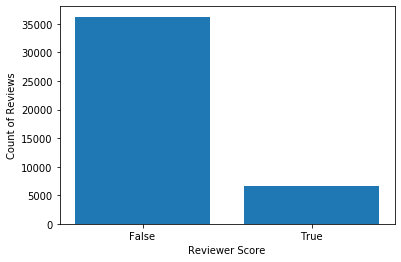

In [43]:
# Plot a histogram that shows the distribution of the scores
values, counts = np.unique(df_reviews['is_spoiler'], return_counts=True)
plt.figure()
plt.bar(["False","True"], counts)
plt.xlabel('Reviewer Score')
plt.ylabel('Count of Reviews')
plt.show()

AS I thought... To get grid of this I will downsample the dominant class

I am not performing ML per se here, I am not so much worried about leaking the data but I thought it is cleaner to split the data into train and test set to help me decide which statistical method to choose to evaluate the text similarity.

Since I will be downsampling my X_train, I will implement my statistical methods on a balanced data and I will tune my threshold using it. To get a better taste of what my threshold will give me using a real life data, I will check the accuracy using the threshold selected on my test data which is still unbalanced. 

In [44]:
from sklearn.model_selection import train_test_split

# Assigning our features to X 
X = dfi.drop(['is_spoiler'], axis=1)
# Assigning our target to y 
y = dfi['is_spoiler']

# Check 
display(X)
display(y)

# Building train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=42 )

,plot_summary,review_text
0,Tracy Flick is running unopposed for this year...,"Popular, but frustrated high school civics tea..."
1,Tracy Flick is running unopposed for this year...,Election is a tricky little film. By making th...
2,Tracy Flick is running unopposed for this year...,SPOILERS THROUGH: Election had been recommende...
3,Tracy Flick is running unopposed for this year...,"Election (1999)Chipper, funny, clever, and wel..."
4,Tracy Flick is running unopposed for this year...,"Reese Witherspoon stars as a perky, studious g..."
...,...,...
39698,An abortion clinic worker with a special herit...,Just say no to humorless comedy. Every joke fa...
39699,An abortion clinic worker with a special herit...,This movie is truly a waste of time and money....
39700,An abortion clinic worker with a special herit...,This is definately the worst movie I have seen...
39701,An abortion clinic worker with a special herit...,Another attempt by the industry to use a vehic...


0         True
1         True
2         True
3         True
4         True
         ...  
39698    False
39699    False
39700    False
39701    False
39702    False
Name: is_spoiler, Length: 39703, dtype: bool

In [45]:
from sklearn.utils import resample
# Downsample
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=42)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine downsample with original data
X_train_bal = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_bal = np.hstack((y_train[y_train == 1], y_downsampled))

Number of class 0 examples before: 31798
Number of class 0 examples after: 5919


In [46]:
X_train = pd.DataFrame(X_train_bal, columns=['plot_summary', 'review_text'])
X_train_wmd = pd.DataFrame(X_train_bal, columns=['plot_summary', 'review_text'])
X_train

,plot_summary,review_text
0,Volcanologist Harry Dalton and mayor Rachel Wa...,The realistic parts in this movie includes the...
1,Nicholas Van Orton is a very wealthy San Franc...,I would like to start out by saying that I lit...
2,"A woman who, by a promise made years earlier, ...","""My Best Friend's Wedding"", really...Even thou..."
3,A research team is sent to an island miles awa...,You will struggle to find a film that is more ...
4,Based off of the comic book. Unbeknownst to ot...,Fast paced and never too serious you cannot he...
...,...,...
11833,The President of the USA goes to Moscow and gi...,Harrison Ford plays a professional president i...
11834,The curse of the headless horseman is the lega...,This movie was absolutely awesome. I am not t...
11835,An abortion clinic worker with a special herit...,I can't remember ever seeing a movie I enjoyed...
11836,"Fletcher Reede, a fast talking attorney, habit...",This movie is much more than just a vehicle fo...


In [47]:
y_train = pd.DataFrame(y_train_bal, columns=['is_spoiler'])
y_train

,is_spoiler
0,True
1,True
2,True
3,True
4,True
...,...
11833,False
11834,False
11835,False
11836,False


Now my data is ready to be processed and converted to vectors!! So let's do that...I will use my previous functions that I wrote `my_tokenizer` and `to_string` to split the text into tokens and retrieved them as a sentence.
Since I already trained my CountVectorizer over the plot of the movies that I have in my previous data I am going to use it to vectorize the plots and the reviews of this dataset as well.

In [48]:
# this function will split the text into tokens after cleaning it
import nltk
import string
import re

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')

    list_of_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings and words with numbers
    for word in listofwords:
        if ((not word in ENGLISH_STOP_WORDS) and (word!='')) and (not re.search("\d", word)):
            # Lemmatize words
            lemmatized_word = lemmatizer.lemmatize(word)
            
            # append the word into the list of listoflemmatized_words
            # in case the word includes the newline \n, we replace with ""
            stemmed_word = stemmer.stem(lemmatized_word)
            list_of_words.append(stemmed_word.replace("\n",''))
            
            
    return list_of_words

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SanaKrichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SanaKrichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
my_tokenizer('The president greets the press in Chicago at 2pm today. The crowd is happy!')

['presid', 'greet', 'press', 'chicago', 'today', 'crowd', 'happi']

In [50]:
#This function will join a list of tokens into a sentence
def to_string(list_of_words):
    return str(" ".join(list_of_words))

I will now convert my plot and reviews into cleaned sentences using the combination of `my_tokenizer` and `to_string` functions

In [51]:
# Convert the plots and reviews into cleaned sentences
for i in X_train.index:
    X_train['plot_summary'].loc[i] = to_string(my_tokenizer(X_train['plot_summary'].loc[i]))
    X_train['review_text'].loc[i] = to_string(my_tokenizer(X_train['review_text'].loc[i]))
    

In [52]:
X_train

,plot_summary,review_text
0,volcanologist harri dalton mayor rachel wando ...,realist part movi includ giant ash cloud come ...
1,nichola van orton wealthi san francisco banker...,would like start say liter creat imdb account ...
2,woman promis made year earlier suppos marri be...,best friend wed reallyeven though dont dislik ...
3,research team sent island mile away previou ho...,struggl find film synonym could lost world ori...
4,base comic book unbeknownst peopl privat agenc...,fast pace never seriou cannot help feel cinema...
...,...,...
11833,presid usa go moscow give stir speech outlin u...,harrison ford play profession presid movi air ...
11834,curs headless horseman legaci small town sleep...,movi absolut awesom type person enjoy violenc ...
11835,abort clinic worker special heritag enlist pre...,cant rememb ever see movi enjoy much dogma one...
11836,fletcher reed fast talk attorney habitu liar d...,movi much vehicl carrey comed geniu also sensi...


In [53]:
# The X_test and y_test still have shuffled indicies so I resetting their index
X_test=X_test.reset_index(drop=True)
# I am saving a copy here for the wmd method
X_test_wmd = X_test.reset_index(drop=True)
X_test 

,plot_summary,review_text
0,Puppeteer Craig Schwartz and animal lover and ...,What a clever and original film! It takes an ...
1,James Bond is back. An oil tycoon is murdered ...,"well, I can't say much for the plot of this mo..."
2,Cultures clash and tempers flares as the two c...,This movie was one of the most funniest movies...
3,Based off of the comic book. Unbeknownst to ot...,''Men in Black'' is a great comedy and sci fi ...
4,It is just another day at the National Aeronau...,Greetings from Lithuania.This movie is in my b...
...,...,...
1981,24 hours in L.A.; it's raining cats and dogs. ...,PT Anderson's sprawling character epic is noth...
1982,James Bond is back. An oil tycoon is murdered ...,The last James Bond film of the 20th century b...
1983,"The evil Trade Federation, led by Nute Gunray ...","Despite what you may hear, The Phantom Menace ..."
1984,"Balls-out ""60 Minutes"" producer Lowell Bergman...",The Insider has an excellent subject to work w...


In [54]:
y_test=y_test.reset_index(drop=True)
y_test 

0       False
1       False
2       False
3        True
4       False
        ...  
1981    False
1982    False
1983    False
1984    False
1985    False
Name: is_spoiler, Length: 1986, dtype: bool

I will be converting the text into clean sentences in my X_test

In [55]:
for i in X_test.index:
    X_test['plot_summary'].loc[i] = to_string(my_tokenizer(X_test['plot_summary'].loc[i]))
    X_test['review_text'].loc[i] = to_string(my_tokenizer(X_test['review_text'].loc[i]))
X_test


,plot_summary,review_text
0,puppet craig schwartz anim lover pet store cle...,clever origin film take outlandish premis some...
1,jame bond back oil tycoon murder bond sent pro...,well cant say much plot movi still think good ...
2,cultur clash temper flare two cop name detect ...,movi one funniest movi seen fill trashtalk act...
3,base comic book unbeknownst peopl privat agenc...,men black great comedi sci fi movi part favori...
4,anoth day nation aeronaut space administr nasa...,greet lithuaniathi movi brain movi soul movi h...
...,...,...
1981,hour la rain cat dog two parallel intercut sto...,pt anderson sprawl charact epic noth short bri...
1982,jame bond back oil tycoon murder bond sent pro...,last jame bond film centuri began spectacular ...
1983,evil trade feder led nute gunray plan take pea...,despit may hear phantom menac truli without do...
1984,ballsout minut produc lowel bergman sniff stor...,insid excel subject work somehow get bit lost ...


In [56]:
# importing bagofwords.pkl 
bagofwords = joblib.load("/Users/SanaKrichen/Desktop/BrainStation/Capstone Project/bagofwords.pkl")

In [57]:
plots_tr=bagofwords.transform(X_train['plot_summary'])

In [58]:
plots_tr

<11838x7160 sparse matrix of type '<class 'numpy.int64'>'
	with 481321 stored elements in Compressed Sparse Row format>

In [59]:
plots_tr=plots_tr.todense()

In [60]:
plots_tr=pd.DataFrame(data=plots_tr, columns=bagofwords.get_feature_names())
plots_tr

,aaron,aback,abandon,abbi,abdomen,abduct,abil,abl,ablaz,aboard,...,youtub,youv,zealand,zero,zip,zoe,zombi,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
reviews_tr=bagofwords.transform(X_train['review_text'])
reviews_tr=reviews_tr.todense()
reviews_tr=pd.DataFrame(data=reviews_tr, columns=bagofwords.get_feature_names())
reviews_tr

,aaron,aback,abandon,abbi,abdomen,abduct,abil,abl,ablaz,aboard,...,youtub,youv,zealand,zero,zip,zoe,zombi,zone,zoo,zoom
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
plots_te=bagofwords.transform(X_test['plot_summary'])
plots_te=plots_te.todense()
plots_te=pd.DataFrame(data=plots_te, columns=bagofwords.get_feature_names())
plots_te

,aaron,aback,abandon,abbi,abdomen,abduct,abil,abl,ablaz,aboard,...,youtub,youv,zealand,zero,zip,zoe,zombi,zone,zoo,zoom
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
reviews_te=bagofwords.transform(X_test['review_text'])
reviews_te=reviews_te.todense()
reviews_te=pd.DataFrame(data=reviews_te, columns=bagofwords.get_feature_names())
reviews_te

,aaron,aback,abandon,abbi,abdomen,abduct,abil,abl,ablaz,aboard,...,youtub,youv,zealand,zero,zip,zoe,zombi,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Cosine Similarity

It is a very widely used method to compare two vectors. Measuring the dot product between two vectors, a cosine similarity close to 0 means that there is not much similarity detected. On the other hand, a cosine that tends to 1 implies an angle of 0 between the 2 vectors and thus, a lot of similarity

In [64]:
result_tr_cosine=pd.DataFrame()
for i in range(len(reviews_tr)):
    cos=float(cosine_similarity(plots_tr.iloc[i,:].values.reshape(1, -1),reviews_tr.iloc[i,:].values.reshape(1, -1)).ravel())
    result_tr_cosine=result_tr_cosine.append(pd.Series({'result' : cos} ),ignore_index=True)

In [65]:
result_tr_cosine

,result
0,0.108465
1,0.050516
2,0.147314
3,0.113023
4,0.139620
...,...
11833,0.151458
11834,0.063671
11835,0.027390
11836,0.091466


In [81]:
my_avg_cosine=[]
for i in list(np.arange(0,1,0.0005)):
    result_tr_cosine['my_spoiler']=np.where(result_tr_cosine['result']>i, 1,0)
    result_tr_cosine['is_spoiler']=y_train['is_spoiler']
    result_tr_cosine['is_correct']=np.where(result_tr_cosine['is_spoiler']==result_tr_cosine['my_spoiler'], 1,0)
    my_avg_cosine.append(result_tr_cosine['is_correct'].mean())
max(my_avg_cosine)
print(f'The accuracy of my X_train is : {max(my_avg_cosine)}')
ind_cosine=my_avg_cosine.index(max(my_avg_cosine))
print(f'The threshold should be: {list(np.arange(0,1,0.0005))[ind_cosine]}')

The accuracy of my X_train is : 0.622909275215408
The threshold should be: 0.0895


In [82]:
# Out of curiosity let's take a peek to the generated dataframe where the threshold = 0.0895
result_tr_cosine['my_spoiler']=np.where(result_tr_cosine['result']>0.0895, 1,0)
result_tr_cosine['is_spoiler']=y_train['is_spoiler']
result_tr_cosine['is_correct']=np.where(result_tr_cosine['is_spoiler']==result_tr_cosine['my_spoiler'], 1,0)
result_tr_cosine

,result,my_spoiler,is_spoiler,is_correct
0,0.108465,1,True,1
1,0.050516,0,True,0
2,0.147314,1,True,1
3,0.113023,1,True,1
4,0.139620,1,True,1
...,...,...,...,...
11833,0.151458,1,False,0
11834,0.063671,0,False,1
11835,0.027390,0,False,1
11836,0.091466,1,False,0


In [83]:
result_tr_cosine['my_spoiler'].sum()

6297

In [84]:
result_tr_cosine['is_correct'].mean()

0.622909275215408

In [85]:
#Test the threshold on my test data and check the accuracy

result_te_cosine=pd.DataFrame()
for i in range(len(reviews_te)):
    cos=float(cosine_similarity(plots_te.iloc[i,:].values.reshape(1, -1),reviews_te.iloc[i,:].values.reshape(1, -1)).ravel())
    result_te_cosine=result_te_cosine.append(pd.Series({'result' : cos} ),ignore_index=True)
result_te_cosine['my_spoiler']=np.where(result_te_cosine['result']>0.0895, 1,0)
result_te_cosine['is_spoiler']=y_test
result_te_cosine['is_correct']=np.where(result_te_cosine['is_spoiler']==result_te_cosine['my_spoiler'], 1,0)
acc=result_te_cosine['is_correct'].mean()
print(f'The accuracy of my X_test is : {acc}')

The accuracy of my X_test is : 0.6027190332326284


Ok.. That's not bad!! The cosine similarity is a pretty simple statistic method and yet it is giving fair results!
Let's check the other methods previously mentioned.


In [79]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(result_te_cosine['is_spoiler'], result_te_cosine['my_spoiler']))

              precision    recall  f1-score   support

       False       0.90      0.57      0.70      1697
        True       0.20      0.64      0.31       289

    accuracy                           0.58      1986
   macro avg       0.55      0.61      0.50      1986
weighted avg       0.80      0.58      0.64      1986



# Jaccard Similarity

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
In terms of the input, I will go one step back in terms of the data processing and will feed it the cleaned sentences

In [39]:
set(X_train['plot_summary'].iloc[0].split(' '))

{'byrun',
 'citi',
 'convinc',
 'council',
 'dahl',
 'dalton',
 'danger',
 'dant',
 'econom',
 'fitjar',
 'harri',
 'inde',
 'interest',
 'mayor',
 'peak',
 'peopl',
 'rachel',
 'rfitjaronlineno',
 'right',
 'safeti',
 'set',
 'tri',
 'volcano',
 'volcanologist',
 'wando',
 'written'}

In [40]:
def get_jaccard_sim(tok1, tok2): 
    a = set(tok1) 
    b = set(tok2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [41]:
result_tr_jaccard=pd.DataFrame()
for i in range(len(reviews_tr)):
    cos=get_jaccard_sim(X_train['plot_summary'].iloc[i].split(' '),X_train['review_text'].iloc[i].split(' '))
    result_tr_jaccard=result_tr_jaccard.append(pd.Series({'result' : cos} ),ignore_index=True)

In [42]:
result_tr_jaccard

,result
0,0.031579
1,0.020202
2,0.073394
3,0.035294
4,0.082090
...,...
11833,0.047059
11834,0.046512
11835,0.016393
11836,0.044643


In [43]:
my_avg_jaccard=[]
for i in list(np.arange(result_tr_jaccard['result'].min(),result_tr_jaccard['result'].max(),0.005)):
    result_tr_jaccard['my_spoiler']=np.where(result_tr_jaccard['result']>i, 1,0)
    result_tr_jaccard['is_spoiler']=y_train['is_spoiler']
    result_tr_jaccard['is_correct']=np.where(result_tr_jaccard['is_spoiler']==result_tr_jaccard['my_spoiler'], 1,0)
    my_avg_jaccard.append(result_tr_jaccard['is_correct'].mean())
print(f'The accuracy of my X_train is : {max(my_avg_jaccard)}')
ind_jaccard=my_avg_jaccard.index(max(my_avg_jaccard))
threshold_jaccard=list(np.arange(result_tr_jaccard['result'].min(),result_tr_jaccard['result'].max(),0.005))[ind_jaccard]
print(f'The threshold should be: {threshold_jaccard}')

The accuracy of my X_train is : 0.616066903193107
The threshold should be: 0.035


In [44]:
# Out of curiosity let's take a peek to the generated dataframe where the threshold = 0.035
result_tr_jaccard['my_spoiler']=np.where(result_tr_jaccard['result']>0.035, 1,0)
result_tr_jaccard['is_spoiler']=y_train['is_spoiler']
result_tr_jaccard['is_correct']=np.where(result_tr_jaccard['is_spoiler']==result_tr_jaccard['my_spoiler'], 1,0)
result_tr_jaccard


,result,my_spoiler,is_spoiler,is_correct
0,0.031579,0,True,0
1,0.020202,0,True,0
2,0.073394,1,True,1
3,0.035294,1,True,1
4,0.082090,1,True,1
...,...,...,...,...
11833,0.047059,1,False,0
11834,0.046512,1,False,0
11835,0.016393,0,False,1
11836,0.044643,1,False,0


In [45]:
result_tr_jaccard['my_spoiler'].sum()

6578

In [46]:
#Test the threshold on my test data and check the accuracy

result_te_jaccard=pd.DataFrame()
for i in range(len(X_test)):
    cos=get_jaccard_sim(X_test['plot_summary'].iloc[i].split(' '),X_test['review_text'].iloc[i].split(' '))
    result_te_jaccard=result_te_jaccard.append(pd.Series({'result' : cos} ),ignore_index=True)
result_te_jaccard['my_spoiler']=np.where(result_te_jaccard['result']>0.035, 1,0)
result_te_jaccard['is_spoiler']=y_test
result_te_jaccard['is_correct']=np.where(result_te_jaccard['is_spoiler']==result_te_jaccard['my_spoiler'], 1,0)
acc_jaccard=result_te_jaccard['is_correct'].mean()
print(f'The accuracy of my X_test is : {acc_jaccard}')

The accuracy of my X_test is : 0.5840886203423967


In [47]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(result_te_jaccard['is_spoiler'], result_te_jaccard['my_spoiler']))

              precision    recall  f1-score   support

       False       0.91      0.57      0.70      1697
        True       0.21      0.68      0.32       289

    accuracy                           0.58      1986
   macro avg       0.56      0.62      0.51      1986
weighted avg       0.81      0.58      0.65      1986



# Word Mover’s Distance


In [51]:
X_train_wmd

,plot_summary,review_text
0,Volcanologist Harry Dalton and mayor Rachel Wa...,The realistic parts in this movie includes the...
1,Nicholas Van Orton is a very wealthy San Franc...,I would like to start out by saying that I lit...
2,"A woman who, by a promise made years earlier, ...","""My Best Friend's Wedding"", really...Even thou..."
3,A research team is sent to an island miles awa...,You will struggle to find a film that is more ...
4,Based off of the comic book. Unbeknownst to ot...,Fast paced and never too serious you cannot he...
...,...,...
11833,The President of the USA goes to Moscow and gi...,Harrison Ford plays a professional president i...
11834,The curse of the headless horseman is the lega...,This movie was absolutely awesome. I am not t...
11835,An abortion clinic worker with a special herit...,I can't remember ever seeing a movie I enjoyed...
11836,"Fletcher Reede, a fast talking attorney, habit...",This movie is much more than just a vehicle fo...


In [52]:
X_test_wmd

,plot_summary,review_text
0,Puppeteer Craig Schwartz and animal lover and ...,What a clever and original film! It takes an ...
1,James Bond is back. An oil tycoon is murdered ...,"well, I can't say much for the plot of this mo..."
2,Cultures clash and tempers flares as the two c...,This movie was one of the most funniest movies...
3,Based off of the comic book. Unbeknownst to ot...,''Men in Black'' is a great comedy and sci fi ...
4,It is just another day at the National Aeronau...,Greetings from Lithuania.This movie is in my b...
...,...,...
1981,24 hours in L.A.; it's raining cats and dogs. ...,PT Anderson's sprawling character epic is noth...
1982,James Bond is back. An oil tycoon is murdered ...,The last James Bond film of the 20th century b...
1983,"The evil Trade Federation, led by Nute Gunray ...","Despite what you may hear, The Phantom Menace ..."
1984,"Balls-out ""60 Minutes"" producer Lowell Bergman...",The Insider has an excellent subject to work w...


In [54]:
# this function will split the text into tokens after cleaning it
import nltk
import string
import re

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def wmd_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    #listoflemmatized_words = []
    list_of_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings and words with numbers
    for word in listofwords:
        if ((not word in ENGLISH_STOP_WORDS) and (word!='')) and (not re.search("\d", word)):
            # Lemmatize words
            list_of_words.append(word.replace("\n",''))
            
            
    return list_of_words

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SanaKrichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SanaKrichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
print(wmd_tokenizer(X_train_wmd['plot_summary'].iloc[0]))

['volcanologist', 'harry', 'dalton', 'mayor', 'rachel', 'wando', 'dantes', 'peak', 'try', 'convince', 'city', 'council', 'volcanologists', 'volcano', 'right', 'dantes', 'peak', 'indeed', 'dangerous', 'peoples', 'safety', 'set', 'economical', 'interests', 'written', 'byrune', 'dahl', 'fitjar', 'rfitjaronlineno']


In [57]:
print(wmd_tokenizer(X_train_wmd['review_text'].iloc[0]))

['realistic', 'parts', 'movie', 'includes', 'giant', 'ash', 'cloud', 'comes', 'volcano', 'looked', 'realistic', 'also', 'volcanic', 'bombs', 'also', 'looked', 'real', 'fired', 'town', 'lava', 'flow', 'also', 'quite', 'good', 'realistic', 'could', 'still', 'see', 'fake', 'still', 'quite', 'good', 'also', 'spider', 'developed', 'nasa', 'also', 'good', 'realisticsome', 'unrealistic', 'parts', 'movie', 'car', 'drove', 'lava', 'able', 'drive', 'fine', 'real', 'life', 'lava', 'would', 'melted', 'metal', 'rims', 'tyres', 'would', 'burst', 'another', 'one', 'harry', 'using', 'shirt', 'push', 'boat', 'acidic', 'water', 'would', 'spashed', 'onto', 'arms', 'like', 'granny', 'jumped', 'water', 'legs', 'arms', 'burnt', 'hercharacters', 'harryvolcomolisistracheltown', 'mayorbusiness', 'ownerpaulus', 'geographical', 'studyharrys', 'boss', 'harry', 'rachel', 'bit', 'romance', 'going', 'harry', 'paul', 'bit', 'conflict', 'volcano', 'explode']


In [59]:
import gensim.models.keyedvectors as word2vec
model = word2vec.KeyedVectors.load_word2vec_format('/Users/SanaKrichen/Desktop/BrainStation/website/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [60]:
result_tr_wmd=pd.DataFrame()
for i in range(len(X_train)):
    a=wmd_tokenizer(X_train['plot_summary'].iloc[i])
    b=wmd_tokenizer(X_train['review_text'].iloc[i])
    dist=model.wmdistance(a,b)
    result_tr_wmd=result_tr_wmd.append(pd.Series({'result' : dist}),ignore_index=True)

In [61]:
result_tr_wmd

,result
0,3.158857
1,2.850629
2,2.360375
3,2.827657
4,2.681392
...,...
11833,2.638582
11834,2.941926
11835,2.947014
11836,2.528654


In [74]:
my_avg_wmd=[]
for i in list(np.arange(result_tr_wmd['result'].min(),result_tr_wmd['result'].max(),0.005)):
    result_tr_wmd['my_spoiler']=np.where(result_tr_wmd['result']>i, 1,0)
    result_tr_wmd['is_spoiler']=y_train['is_spoiler']
    result_tr_wmd['is_correct']=np.where(result_tr_wmd['is_spoiler']==result_tr_wmd['my_spoiler'], 1,0)
    my_avg_wmd.append(result_tr_wmd['is_correct'].mean())
print(f'The accuracy of my X_train is : {max(my_avg_wmd)}')
ind_wmd=my_avg_wmd.index(max(my_avg_wmd))
threshold_wmd=list(np.arange(result_tr_wmd['result'].min(),result_tr_wmd['result'].max(),0.005))[ind_wmd]
print(f'The threshold should be: {threshold_wmd}')

The accuracy of my X_train is : 0.5
The threshold should be: 3.6455610350069985


Surprisingly it is not doing well at all!! I honestly expected way more.. Let's take a peek at the `result_tr_wmd` dataframe for the chosen threshold

In [63]:

result_tr_wmd['my_spoiler']=np.where(result_tr_wmd['result']>3.645, 1,0)
result_tr_wmd['is_spoiler']=y_train['is_spoiler']
result_tr_wmd['is_correct']=np.where(result_tr_wmd['is_spoiler']==result_tr_wmd['my_spoiler'], 1,0)
result_tr_wmd

,result,my_spoiler,is_spoiler,is_correct
0,3.158857,0,True,0
1,2.850629,0,True,0
2,2.360375,0,True,0
3,2.827657,0,True,0
4,2.681392,0,True,0
...,...,...,...,...
11833,2.638582,0,False,1
11834,2.941926,0,False,1
11835,2.947014,0,False,1
11836,2.528654,0,False,1


In [76]:
#Test the threshold on my test data and check the accuracy
result_te_wmd=pd.DataFrame()
for i in range(len(X_test)):
    a=wmd_tokenizer(X_test['plot_summary'].iloc[i])
    b=wmd_tokenizer(X_test['review_text'].iloc[i])
    dist=model.wmdistance(a,b)
    result_te_wmd=result_te_wmd.append(pd.Series({'result' : dist}),ignore_index=True)
    
result_te_wmd['my_spoiler']=np.where(result_te_wmd['result']>3.645, 1,0)
result_te_wmd['is_spoiler']=y_test
result_te_wmd['is_correct']=np.where(result_te_wmd['is_spoiler']==result_te_wmd['my_spoiler'], 1,0)
acc_wmd_te=result_te_wmd['is_correct'].mean()
print(f'The accuracy of my X_test is : {acc_wmd_te}')

The accuracy of my X_test is : 0.8544813695871097


In [78]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(result_te_wmd['is_spoiler'], result_te_wmd['my_spoiler']))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92      1697
        True       0.00      0.00      0.00       289

    accuracy                           0.85      1986
   macro avg       0.43      0.50      0.46      1986
weighted avg       0.73      0.85      0.79      1986



/Users/SanaKrichen/opt/anaconda3/envs/distance/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As expected.. We should not be so impressed with the high accuracy... It doesn't mean anything here since it is really classifying all the reviews as non spoilers.. The data is highly unbalanced in favor of non spoiler reviews so that's why we are getting that high accuracy. The classification report is exposing what I just mentioned here.

# Conclusion 

I will implement the Cosine similarity method to compare reviews and plots in my movie app. The threshold will be set at 0.0895. With an accuracy of 60% and a recall of 64% on the test set, I would say that those are fair results.
